**Disclaimer:** I am reusing the preclass work notebook from class 2.2 and extending the work at the bottom.

# Call center data modeling

You are advising a client on the number of call center agents they need to handle their customer support load. We start by modeling the number of phone calls we expect to come into the call center during each hour of the day.

You are provided with a data set of the intervals between phone calls arriving during one day. Each value is a time in minutes indicating the amount of time that passed between receiving two consecutive phone calls.

## Loading the data

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load the data set containing durations between calls arriving at the call
# center during 1 day. All values are in minutes.
waiting_times_day = np.loadtxt('call_center.csv')

# Display some basic information about the data set.
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Total hours of data:', sum(waiting_times_day/60))

Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2]
Total hours of data: 24.028063589666747


Since the values are intervals between calls measured in minutes, this means

* we assume the first call happened at 00:00 (midnight),
* the second call happened at about 00:30 (30 minutes after midnight),
* the third call happened at about 00:33 (30 + 3.4 minutes),
* the fourth call happened at about 00:37, etc.

When we sum the values, we get about 1440 minutes (1 day).

You are told that the number of calls arriving varies quite a lot, depending on which hour of the day it is. The smallest number of calls usually occur around 3am or 4am. Most calls usually come in between 11am and 1pm.

## Data pre-processing
Since we expect different call rates during different hours, we split the data set into 24 separate series — one for each hour of the day.

In [3]:
# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

for hour, calls_in_hour in enumerate(waiting_times_per_hour):
    print(f'{hour:02}:00-{hour + 1:02}:00 - {len(calls_in_hour)} calls')

00:00-01:00 - 5 calls
01:00-02:00 - 4 calls
02:00-03:00 - 6 calls
03:00-04:00 - 8 calls
04:00-05:00 - 26 calls
05:00-06:00 - 53 calls
06:00-07:00 - 93 calls
07:00-08:00 - 173 calls
08:00-09:00 - 254 calls
09:00-10:00 - 345 calls
10:00-11:00 - 496 calls
11:00-12:00 - 924 calls
12:00-13:00 - 858 calls
13:00-14:00 - 382 calls
14:00-15:00 - 185 calls
15:00-16:00 - 207 calls
16:00-17:00 - 263 calls
17:00-18:00 - 419 calls
18:00-19:00 - 531 calls
19:00-20:00 - 400 calls
20:00-21:00 - 137 calls
21:00-22:00 - 51 calls
22:00-23:00 - 20 calls
23:00-24:00 - 16 calls


## Task 1: Plot the number of calls per hour
Use Matplotlib to visualize the number of calls that arrive during each hour of the day, stored in the variable `waiting_times_per_hour`. The call numbers are shown in the output above. You should find an appropriate way to visualize it.

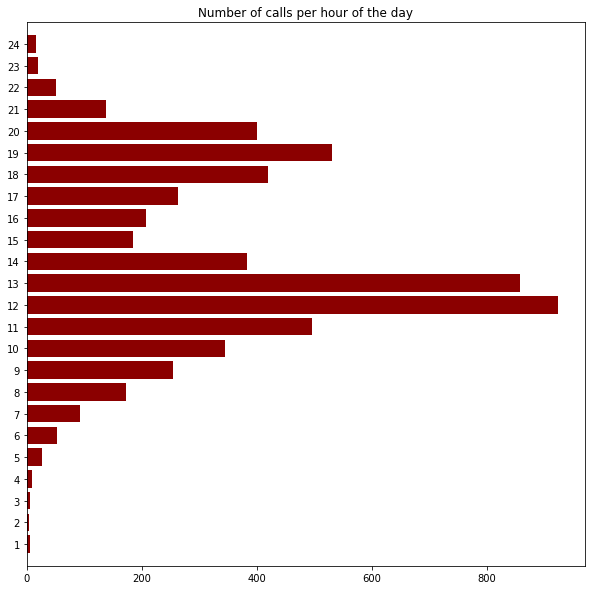

In [4]:
plt.figure(figsize=(10,10))

plot_calls = [len(calls) for calls in waiting_times_per_hour]
hours = [h for h in range(1,25)]

plt.barh(hours, plot_calls, tick_label=hours, color='darkred')
plt.title("Number of calls per hour of the day")
plt.ylim(0,25)
plt.show()

## Task 2: Plot a histogram of the durations for one hour
Take the data for the 9th hour (so between 9am and 10am) and plot a histogram showing the distribution over waiting times between calls during that hour.

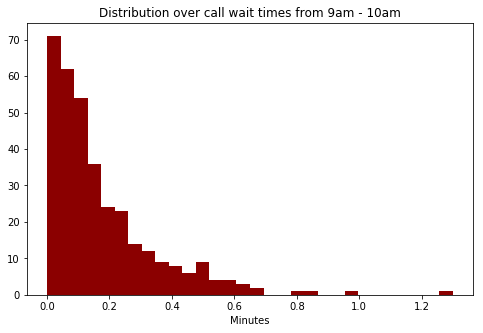

In [5]:
plt.figure(figsize=(8,5))

plt.hist(waiting_times_per_hour[9], color='darkred', bins=30)
plt.xlabel("Minutes")
plt.title("Distribution over call wait times from 9am - 10am")
plt.show()

## Task 3: Guess the distribution
What type of distribution best represents the data in your histogram?

* Identify a type of distribution. **In class you will use this distribution as your likelihood function in a Bayesian inference problem.**
* Guess what the parameters of the distribution are. (This is just a guess for now. In class we will infer the values of the parameters.)
* Plot the pdf of your best guess on top of your histogram, to see if they match.

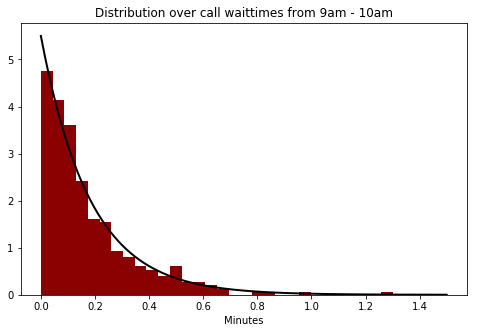

In [6]:
plt.figure(figsize=(8,5))

x = np.linspace(0, 1.5, 200) 
_lambda = 5.5

plt.plot(x, stats.expon.pdf(x, scale=1/_lambda), label='distribution', color='k', linewidth=2)
plt.hist(waiting_times_per_hour[9], color='darkred', bins=30, density=True)
plt.xlabel("Minutes")
plt.title("Distribution over call waittimes from 9am - 10am")
plt.show()

## Infering Lambda and its Confidence Intervals

Fit an exponential distribution to the data for a single hour.

1. We do Bayesian inference on this problem.
2. Use the **exponential distribution** as your **likelihood function**. You need to fill in the `likelihood` function below.
3. Use a **gamma distribution** with parameters $\alpha=1$ and $\beta=0.25$ as your **prior**. You need to fill in the `prior` function below.
4. **Compute the posterior distribution over $\lambda$.**
5. **Plot the prior and posterior** distributions on the same axes.

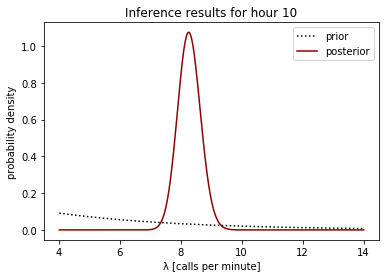

In [7]:
def likelihood(lambda_, datum):
    return stats.expon(scale=1/lambda_).pdf(datum)

def prior(lambda_):
    return stats.gamma(1, scale=1/0.25).pdf(lambda_)

def compute_posterior(parameter_values, prior, likelihood, data):
    log_prior = np.log(prior(parameter_values))
    log_likelihood = np.array([np.sum(np.log(likelihood(param, data))) for param in parameter_values])
    unnormalized_log_posterior = log_prior + log_likelihood
    unnormalized_log_posterior -= max(unnormalized_log_posterior)
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

lambdas = np.linspace(4, 14, 501)[1:]
posterior = compute_posterior(lambdas, prior, likelihood, waiting_times_per_hour[10])

# YOU NEED TO PLOT THE PRIOR AND POSTERIOR ON THE SAME AXES.
plt.figure(figsize=(6, 4))
plt.plot(lambdas, prior(lambdas), color='black', linestyle=':', label='prior')
plt.plot(lambdas, posterior, color='darkred', label='posterior')
plt.xlabel('λ [calls per minute]')
plt.ylabel('probability density')
plt.title(f'Inference results for hour 10')
plt.legend()
plt.show()

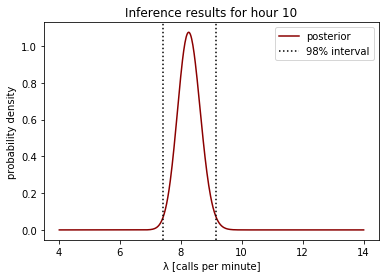

Posterior 98% interval: [7.42, 9.16] calls per minute


In [8]:
def compute_percentile(parameter_values, distribution_values, percentile):
    '''
    Compute the parameter value at a particular percentile of the given
    probability distribution values. This function uses the cumulative trapezoid
    integrator in SciPy.
    '''
    cumulative_distribution = sp.integrate.cumtrapz(
        distribution_values, parameter_values)
    percentile_index = np.searchsorted(cumulative_distribution, percentile)
    return lambdas[percentile_index]


plt.figure(figsize=(6,4))
plt.plot(lambdas, posterior, color='darkred', label='posterior')
plt.axvline(percentiles[0], color='black', linestyle=':', label='98% interval')
plt.axvline(percentiles[1], color='black', linestyle=':')
plt.xlabel('λ [calls per minute]')
plt.ylabel('probability density')
plt.title(f'Inference results for hour 10')
plt.legend()
plt.show()

print('Posterior 98% interval:', percentiles, 'calls per minute')

In [9]:
# Get the posterior expected value of λ
lambda_ = sp.integrate.trapz(posterior * lambdas, lambdas)
print('Expected value: λ =', lambda_, 'calls per minute')

Expected value: λ = 8.279476477207703 calls per minute


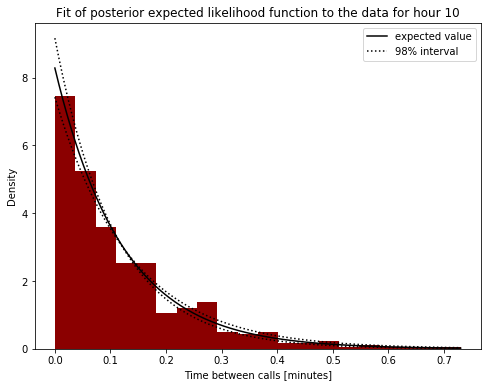

In [10]:

# Plot the likelihood function for the expected λ on top of the data histogram
plt.figure(figsize=(8, 6))
plt.hist(waiting_times_per_hour[10], bins=20, density=True, color='darkred')
x = sp.linspace(0, max(waiting_times_per_hour[10]), 200)
plt.plot(x, stats.expon.pdf(x, scale=1/lambda_), color='k', label='expected value')
plt.plot(x, stats.expon.pdf(x, scale=1/percentiles[0]), color='k', linestyle=':', label='98% interval')
plt.plot(x, stats.expon.pdf(x, scale=1/percentiles[1]), color='k', linestyle=':')
plt.xlabel('Time between calls [minutes]')
plt.ylabel('Density')
plt.title(f'Fit of posterior expected likelihood function to the data for hour 10')
plt.legend()
plt.show()

## Extension to 24 Hours
In class, we completed the Bayesian data modeling problem for 1 hour of the day. In this
assignment, you need to do the same analysis for all 24 hours of the day.
1. Compute a 98% posterior confidence interval over the number of calls per minute (the call
rate λ ) for each hour of the day — so you will have 24 confidence intervals. Also, compute
the posterior mean of λ for each hour of the day.
2. Present your results graphically using Matplotlib. Make a plot where each dot is at the posterior mean and each error bar line shows a 98% confidence interval for a λ.

In [11]:
#This array will contain EV/mean, CI_low, CI_high for each hour.
daily_stats = np.zeros((3,24))
lambdas = np.linspace(0, 20, 501)[1:]


for hour, data in enumerate(waiting_times_per_hour):
    #calculate EV & CIs for all hours of the day
    posterior = compute_posterior(lambdas, prior, likelihood, data)
    percentiles = [compute_percentile(lambdas, posterior, p) for p in [0.01, 0.99]]
    EV = sp.integrate.trapz(posterior * lambdas, lambdas)
    
    daily_stats[:,hour] = [EV,  percentiles[0], percentiles[1]]

In [12]:
#Computing relative differences for error bars
daily_stats[1,:] = daily_stats[0,:] - daily_stats[1,:]
daily_stats[2,:] = daily_stats[2,:] - daily_stats[0,:] 

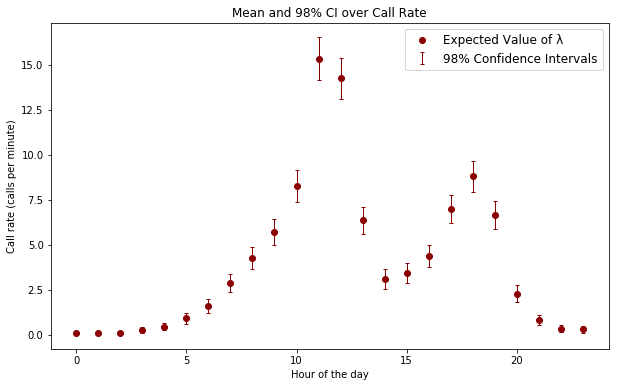

In [17]:
plt.figure(figsize=(10,6))
plt.scatter(range(24), daily_stats[0,:], color='darkred', label='Expected Value of λ')
plt.errorbar(range(24), daily_stats[0,:], yerr=daily_stats[1:,:],
             fmt='none', ecolor='darkred', elinewidth=1, capsize=2,
             label='98% Confidence Intervals')

plt.xlabel('Hour of the day')
plt.ylabel('Call rate (calls per minute)')
plt.title('Mean and 98% CI over Call Rate')
plt.legend(prop={'size': 12})
plt.show()

Write a paragraph (100–200 words) to accompany your plot and present your findings to
the client. Carefully summarize how many calls you expect during different parts of the day,
and how much uncertainty there is in your estimates. Remember that the client is not an
expert in statistics, so make it easy for them to understand. You may also make additional
plots to help communicate your results.

> The above plot represents our best estimate at how many calls there will be per minute for each hour of the day. The dots indicate the average number of requests that we would expect at any given hour (i.e., between 11 am & noon, we anticipate roughly 15 calls per minute). The error bars represent how certain we are about this estimate of the average number of calls (i.e., for the previously mentioned period, we are rather confident that the average number of calls will lie between ~13-16). The above plot *does not* mean, that the actual number of calls cannot fall outside the errorbars and it contains no information about the variance of the data, just the confidence in our estimate of the mean.

> For example, it is possible that during the same period mentioned above, we receive 50 calls during a single minute and only two calls just a few minutes later. This is, of course, unlikely (the further the data lies from the mean, the less likely it is), but not implausible. As such, we recommend staffing for the upper bound of the average number of calls we would expect during any given hour, with some additional safety built-in during the peak hours and then continuing this data investigation to get an estimate of the expected variance of the data for each hour. 